In [1]:
import requests
import pickle
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
import warnings
import nltk.corpus
import sparse_dot_topn.sparse_dot_topn as ct
from os.path import exists
from nltk.corpus import stopwords
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx

In [2]:
cats = requests.get('https://api.mercadolibre.com/sites/MCO/categories')
cats.json()

[{'id': 'MCO1747', 'name': 'Accesorios para Vehículos'},
 {'id': 'MCO441917', 'name': 'Agro'},
 {'id': 'MCO1403', 'name': 'Alimentos y Bebidas'},
 {'id': 'MCO1071', 'name': 'Animales y Mascotas'},
 {'id': 'MCO1367', 'name': 'Antigüedades y Colecciones'},
 {'id': 'MCO1368', 'name': 'Arte, Papelería y Mercería'},
 {'id': 'MCO1384', 'name': 'Bebés'},
 {'id': 'MCO1246', 'name': 'Belleza y Cuidado Personal'},
 {'id': 'MCO40433', 'name': 'Boletas para Espectáculos'},
 {'id': 'MCO1039', 'name': 'Cámaras y Accesorios'},
 {'id': 'MCO1743', 'name': 'Carros, Motos y Otros'},
 {'id': 'MCO1051', 'name': 'Celulares y Teléfonos'},
 {'id': 'MCO1648', 'name': 'Computación'},
 {'id': 'MCO1144', 'name': 'Consolas y Videojuegos'},
 {'id': 'MCO172890', 'name': 'Construcción'},
 {'id': 'MCO1276', 'name': 'Deportes y Fitness'},
 {'id': 'MCO5726', 'name': 'Electrodomésticos'},
 {'id': 'MCO1000', 'name': 'Electrónica, Audio y Video'},
 {'id': 'MCO175794', 'name': 'Herramientas'},
 {'id': 'MCO1574', 'name': 'Ho

In [3]:
product_id = "MCO1648"
offset = 1
url = f'https://api.mercadolibre.com/sites/MCO/search?category={product_id}&offset={offset}'
request = requests.get(url)
items = request.json()

In [4]:
results = items['results'][0]

In [5]:
class API():

    def __init__(self, country_code, product_id = None):
        """
        Initialization API class

        Parameters:

        :country_code (string): country code 
        :product_id (string): product_id of the country code
        :return: API Object.
        """
        if exists("API.pickle"):
            try:
                file_to_read = open("API.pickle", "rb")
                loaded_object = pickle.load(file_to_read)
                self.country_code = loaded_object.country_code
                self.product_id = loaded_object.product_id            
                self.database = loaded_object.database
                self.last_offset = loaded_object.last_offset
                file_to_read.close()
            except:
                print("No se pudo cargar archivo")
        else:             
            self.country_code = country_code
            self.product_id = product_id            
            self.database = pd.DataFrame()
            self.last_offset = 0

    def update_information(self, offset = None):
        """
        Download information/Update information

        Parameters:

        :offset (int): number benchmark to consider download the 50s items
        :return (DataFrame): Database with the downloaded information
        """
        if pd.isnull(offset):
            offset = self.last_offset
        try: 
            # -------------------
            # Request API
            # -------------------
            url = f'https://api.mercadolibre.com/sites/MCO/search?category={product_id}&offset={offset}'
            request = requests.get(url)
            items = request.json()
            items = items['results']

            # -------------------
            # Data Wrangling
            # -------------------
            database_dict = {}
            # Manera optima de añadir informacion a dataframe
            # link : https://stackoverflow.com/questions/27929472/improve-row-append-performance-on-pandas-dataframes
            for index, item in enumerate(items):
                database_dict[index] = {attribute : item[attribute] for attribute in item}
            
            database_offset = pd.DataFrame.from_dict(database_dict, "index")
            self.database = self.database.append(database_offset)
            self.last_offset += 50
        except:
            print(f"No se pudo correr informacion de offset={offset}")
    
    def save(self):
        """
        Save database

        Parameters:

        :return (pickel): API pickle object
        """
        file_to_store = open("API.pickle", "wb")
        pickle.dump(self, file_to_store)
        file_to_store.close()

    def delete(self):
        """
        Delete pickle API object

        Parameters:

        :return (pickle): Database with the downloaded information
        """
        if exists("API.pickle"):
            os.remove("API.pickle")

In [6]:
# ----------------------------
# 1. Downloading Information
# ----------------------------
run_download = False
country_code = "MCO"
# Celulares
product_id = "MCO1648"
if run_download:
    information = API(country_code, product_id)
    offset_list = [x*50 for x in range(1,20)]
    for offset_i in offset_list:
        information.update_information(offset_i)
    del offset_list
    information.save()
else:
    information = API(country_code, product_id)


In [7]:
# ----------------------------
# 2. Process 
# ----------------------------

In [16]:
class Text_similarity():
    
    def __init__(self, items = None):
        """
        Initialization Text similarity object

        Parameters:

        :return (None):
        """
        if items is None: items = []
        self.l = items        
        self.elbow_value = None

    def clean_text(self, text):
        """
        Preprocessing cleaning corpus.

        Parameters:

        :text (string): text to be cleaned.
        :return (None):
        """
        # Link: https://monkeylearn.com/blog/text-cleaning/
        # Normalize text
        text = text.lower()
        # Remove unicode text
        text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
        # Remove stop words
        stop = stopwords.words('spanish')
        text = " ".join([word for word in text.split() if word not in (stop)])
        return text
        
    def ngrams(self, string, n=3):
        """
        Generate n-grams for a string.

        Parameters:

        :return (List): List with n-grams of the string.
        """
        ngrams = zip(*[string[i:] for i in range(n)])
        return [''.join(ngram) for ngram in ngrams]

    def awesome_cossim_top(self, tf_idf_matrix, tf_idf_matrix_transpose, ntop, lower_bound = 0):
        """
        Generate sparse matrix with cosine distance on TF-IDF Matrix

        Parameters:
        :tf_idf_matrix (Scipy Sparce Matrix): TF-IDF Matrix (sentence, ngram).
        :tf_idf_matrix_transpose (Scipy Sparce Matrix): TF-IDF Matrix Transpose (ngram, sentence).
        :ntop (int): top-n cosine similarity score.
        :lower_bound (int): if value of an element of C is less than lower_bound, the value will be replaced zero.
        
        :return (Csr_matrix):csr_matrix with top-n cosine similarity.
        """
        # force A and B as a CSR matrix.
        # If they have already been CSR, there is no overhead
        tf_idf_matrix = tf_idf_matrix.tocsr()
        tf_idf_matrix_transpose = tf_idf_matrix_transpose.tocsr()
        # Number of Sentences
        M, _ = tf_idf_matrix.shape
        # Number of ngrams
        _, N = tf_idf_matrix_transpose.shape
    
        idx_dtype = np.int32

        # Closest sentences
        nnz_max = M*ntop
    
        indptr = np.zeros(M+1, dtype = idx_dtype)
        indices = np.zeros(nnz_max, dtype = idx_dtype)
        data = np.zeros(nnz_max, dtype = tf_idf_matrix.dtype)

        # Link explanation:  https://medium.com/wbaa/https-medium-com-ingwbaa-boosting-selection-of-the-most-similar-entities-in-large-scale-datasets-450b3242e618
        # Link2 :https://towardsdatascience.com/finding-word-similarity-using-tf-idf-in-a-term-context-matrix-from-scratch-in-python-e423533a407
        ct.sparse_dot_topn(
            M, 
            N, 
            np.asarray(tf_idf_matrix.indptr, dtype = idx_dtype),
            np.asarray(tf_idf_matrix.indices, dtype = idx_dtype),
            tf_idf_matrix.data,
            np.asarray(tf_idf_matrix_transpose.indptr, dtype = idx_dtype),
            np.asarray(tf_idf_matrix_transpose.indices, dtype = idx_dtype),
            tf_idf_matrix_transpose.data,
            ntop,
            lower_bound,
            indptr, 
            indices, 
            data)
        return csr_matrix((data, indices, indptr),shape=(M, N))

    def get_matches_df(self, sparse_matrix, sentences_vector, prices, links, clustering_target, top = None):
        """
        Generate database of matches with their respectives prices and urls to check.

        Parameters:
        :sparse_matrix (Scipy Sparce Matrix): TF-IDF Matrix (sentence, ngram).
        :sentences_vector (DataFrame): Dataframe with titles.
        :prices (DataFrame): Dataframe with prices.
        :links (int):  Dataframe with URLS.
        
        :return (Dataframe ): database of matches with their respectives prices and urls to check.
        """
        non_zeros = sparse_matrix.nonzero()
        clustering_target = pd.DataFrame(clustering_target)
        # Number of setences
        sparserows = non_zeros[0]
        # Numebr of n-grams
        sparsecols = non_zeros[1]
        
        if top:
            nr_matches = top
        else:
            nr_matches = sparserows.size
        
        # Initialize Variables of the Dataframe
        left_side = np.empty([nr_matches], dtype=object)
        right_side = np.empty([nr_matches], dtype=object)
        similairity = np.zeros(nr_matches)
        prices_left = np.empty([nr_matches], dtype=object)
        links_left = np.empty([nr_matches], dtype=object)
        prices_right = np.empty([nr_matches], dtype=object)
        links_right = np.empty([nr_matches], dtype=object)
        clustering_left = np.empty([nr_matches], dtype=object)
        clustering_right = np.empty([nr_matches], dtype=object)

        # Star the matching with all possible matches
        for index in range(0, nr_matches):
            left_side[index] = sentences_vector.iloc[sparserows[index]]
            right_side[index] = sentences_vector.iloc[sparsecols[index]]
            similairity[index] = sparse_matrix.data[index]

            prices_left[index] = prices.iloc[sparserows[index]]
            links_left[index] = links.iloc[sparserows[index]]
            clustering_left[index] = clustering_target.iloc[sparserows[index]]

            prices_right[index] = prices.iloc[sparsecols[index]]
            links_right[index] = links.iloc[sparsecols[index]]
            clustering_right[index] = clustering_target.iloc[sparsecols[index]]


        return pd.DataFrame({'left_side': left_side,
                            'right_side': right_side,
                            'similarity': similairity,
                            'left price': prices_left,
                            'right price': prices_right,
                            'left URL': links_left,
                            'right URL': links_right,
                            })

    def elbow_score_kmeans(self, td_idf_matrix, limit = 20):
        warnings.filterwarnings('ignore')
        result = kelbow_visualizer(KMeans(random_state=4), tf_idf_matrix, k = (3, limit))
        self.elbow_value = result.elbow_value_
        return None
        
    def kmeans_text(self, tf_idf_matrix, titles, plot = True):
        kmeans = KMeans(n_clusters = self.elbow_value).fit(tf_idf_matrix)
        cluster_target = kmeans.predict(tf_idf_matrix)
        svd = TruncatedSVD(n_components = 2)

        X_svd = svd.fit_transform(tf_idf_matrix)
        X_svd_df = pd.DataFrame(X_svd)
        X_svd_df.reset_index(drop = True, inplace = True)
        titles.reset_index(drop = True, inplace = True)

        X_svd_df['titles'] = titles

        if plot == True:
            fig = px.scatter(
                pd.DataFrame(X_svd_df), x = 0, y = 1,
                color = cluster_target,
                title = "Text Clustering",
                hover_data ={'titles':True}
            )

            fig.update_layout(
                xaxis_title="1 Dimension Reduction",
                yaxis_title="2 Dimension Reduction",
            )
            
            fig.show()
        return cluster_target

    def plot_network(self, G):
        # Generate the layout and set the 'pos' attribute
        pos = nx.drawing.layout.spring_layout(G)
        nx.set_node_attributes(G, pos, 'pos')

        edge_x = []
        edge_y = []
        for edge in G.edges():
            x0, y0 = G.nodes[edge[0]]['pos']
            x1, y1 = G.nodes[edge[1]]['pos']
            edge_x.append(x0)
            edge_x.append(x1)
            edge_x.append(None)
            edge_y.append(y0)
            edge_y.append(y1)
            edge_y.append(None)

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines')

        node_x = []
        node_y = []
        for node in G.nodes():
            x, y = G.nodes[node]['pos']
            node_x.append(x)
            node_y.append(y)

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers',
            hoverinfo='text',
            marker=dict(
                showscale=True,
                # colorscale options
                #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
                #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
                #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
                colorscale='Earth',
                reversescale=True,
                color=[],
                size=10,
                colorbar=dict(
                    thickness=15,
                    title='Node Connections',
                    xanchor='left',
                    titleside='right'
                ),
                line_width=2))

        node_adjacencies = []
        node_text = []
        for node, adjacencies in enumerate(G.adjacency()):
            node_adjacencies.append(len(adjacencies[1]))
            node_text.append(f'{adjacencies[0]} - # of connections: '+str(len(adjacencies[1])))

        node_trace.marker.color = node_adjacencies
        node_trace.text = node_text

        fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'Text Clustering Cosine-Similarity with TF IDF - {similarity_bound}' ,
                        #titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)),
                        )
        fig.show()
        return None

    def return_groups_network(self, G, matches_df):
        dfgroup = pd.DataFrame()

        for n, i in enumerate(nx.connected_components(G)):
            arr = np.array(list(i))
            s = [node in matches_df['left_side'].tolist() for node in i]
            node_r = arr[s]
            df_r = pd.DataFrame({'Product Titles':[node_r]} ,
                                index=[n]) 
            dfgroup = pd.concat([dfgroup,df_r])

        dfgroup = dfgroup.rename_axis('Group Number').reset_index()
        return dfgroup

In [17]:
# -------------------
# Parameters
# ----------------
similarity_bound = 0.8

text_similarity = Text_similarity()
# Clean text titles
information.database['title'] = information.database['title'].apply(text_similarity.clean_text)
# TD - IDF words
titles = information.database['title']
vectorizer = TfidfVectorizer(min_df = 1, analyzer = text_similarity.ngrams)
tf_idf_matrix = vectorizer.fit_transform(titles)

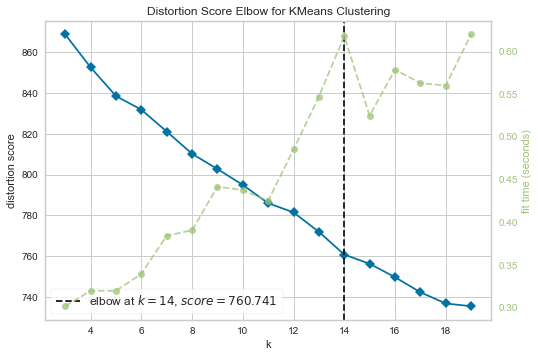

In [18]:
text_similarity.elbow_score_kmeans(tf_idf_matrix, limit = 20)

In [21]:
titles = information.database['title']
clustering_target = text_similarity.kmeans_text(tf_idf_matrix, titles)

In [22]:
prices = information.database['price']
links = information.database['permalink']
matches = text_similarity.awesome_cossim_top(tf_idf_matrix, tf_idf_matrix.transpose(), 10, similarity_bound)
matches_df = text_similarity.get_matches_df(matches, titles, prices, links, clustering_target)
matches_df = matches_df[matches_df['similarity'] < 0.99999] # For removing all exact matches
matches_df.head()

,left_side,right_side,similarity,left price,right price,left URL,right URL
2,switch tplink ls1005g serie litewave,switch tplink ls1005 serie litewave,0.908829,61000,48700,https://www.mercadolibre.com.co/switch-tp-link...,https://www.mercadolibre.com.co/switch-tp-link...
3,switch tplink ls1005g serie litewave,switch tplink ls1008 serie litewave,0.858817,61000,48514,https://www.mercadolibre.com.co/switch-tp-link...,https://www.mercadolibre.com.co/switch-tp-link...
5,laptop dell inspiron 3505 negra 156 amd ryzen ...,laptop dell inspiron 3505 negra 156 amd ryzen ...,0.868964,2200000,2061000,https://www.mercadolibre.com.co/laptop-dell-in...,https://www.mercadolibre.com.co/laptop-dell-in...
6,laptop dell inspiron 3505 negra 156 amd ryzen ...,laptop dell inspiron 3505 gris 156 amd ryzen 5...,0.861397,2200000,2183650,https://www.mercadolibre.com.co/laptop-dell-in...,https://www.mercadolibre.com.co/laptop-dell-in...
7,laptop dell inspiron 3505 negra 156 amd ryzen ...,laptop dell inspiron 3505 gris 156 amd ryzen 5...,0.854644,2200000,2182070,https://www.mercadolibre.com.co/laptop-dell-in...,https://www.mercadolibre.com.co/laptop-dell-in...


In [23]:
fig = px.histogram(matches_df, x="similarity")
fig.update_layout(bargap=0.2)
fig.show()

In [24]:
G = nx.from_pandas_edgelist(matches_df, source = "left_side", target = 'right_side')
text_similarity.plot_network(G)

In [25]:
group_network = text_similarity.return_groups_network(G, matches_df)
group_network

,Group Number,Product Titles
0,0,"[switch tplink ls1008 serie litewave, switch t..."
1,1,[laptop dell inspiron 3505 gris 156 amd ryzen ...
2,2,[laptop hp 245 g7 negra 14 amd athlon 3020e 8g...
3,3,[memoria usb kingston datatraveler 100 g3 dt10...
4,4,[laptop dell inspiron 3501 negra 156 intel cor...
...,...,...
105,105,[portatil hp intel i3 10110u ssd 256gb ram 12g...
106,106,[tableta digitalizadora wacom intuos m bluetoo...
107,107,[base gamer refrigerante porttil 5 niveles 1 v...
108,108,[disco duro externo toshiba 1tb tera estuche a...


In [26]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image

In [134]:
class Image_Similarity():

    def __init__(self, image_shape):
        """
        Initialization Text similarity object

        Parameters:

        :return (None):
        """
        self.image_shape = image_shape 
        self.model = None  
        self.database = pd.DataFrame()
        self.root_folder = os.path.dirname(os.path.abspath(os.curdir)) + "\Mercado_libre"
        
    def process_image_dir(self, image_dir):
        image = tf.keras.preprocessing.image.load_img(image_dir, target_size = self.image_shape )
        #image = np.stack((image,)*3, axis=-1)   
        image = np.array(image)/255.0 
        return image

    def load_model(self, model_url):
        layer = hub.KerasLayer(model_url, input_shape = self.image_shape+(3,))
        model = tf.keras.Sequential([layer])
        self.model = model
        return None    

    def embedding_image(self, image):
        try: 
            embedding = self.model.predict(image[np.newaxis, ...])
            embedding_np = np.array(embedding)
            flattended_feature = embedding_np.flatten()
            return flattended_feature
        except:
            print("No a cargado modelo")

    def generate_embedding_database(self, row):
        image_dir = row['dir_image']
        image = image_similarity.process_image_dir(image_dir)
        embedding_image = image_similarity.embedding_image(image)

        
        database_dict = {}
        # Manera optima de añadir informacion a dataframe
        # link : https://stackoverflow.com/questions/27929472/improve-row-append-performance-on-pandas-dataframes
        database_dict[row.name] = {index :embedding_image[index] for index in range(len(embedding_image))}
        database_dict[row.name].update({"title" : row['title']})

        database_offset = pd.DataFrame.from_dict(database_dict, "index")
        self.database = self.database.append(database_offset)
        return 

    def save(self):
        """
        Save database

        Parameters:

        :return (pickel): API pickle object
        """
        file_to_store = open("Images.pickle", "wb")
        pickle.dump(self, file_to_store)
        file_to_store.close()

    def delete(self):
        """
        Delete pickle API object

        Parameters:

        :return (pickle): Database with the downloaded information
        """
        if exists("Images.pickle"):
            os.remove("API.pickle")

    def download_images(self, row):
        images_folder = self.root_folder + "\Images"
        filename = os.path.join(images_folder,
                                '_'.join([str(row.name),
                                            row['title']]))
        filename += '.jpg'

        # create folder if it doesn't exist
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        url = row['thumbnail']
        print(f"Downloading {url} to {filename}")
        r = requests.get(url, allow_redirects=True)
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename

In [135]:
image_url = "http://http2.mlstatic.com/D_937180-MLA49203208800_022022-I.jpg"
model_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"
IMAGE_SHAPE = (224, 224)

image_similarity = Image_Similarity(IMAGE_SHAPE)
image_similarity.load_model(model_url)

In [ ]:
run_download_image = False
if run_download_image:
    information.database['dir_image'] = information.database.apply(lambda x: image_similarity.download_images(x), axis = 1)

In [136]:
information.database.apply(lambda x: image_similarity.generate_embedding_database(x), axis = 1)

0     None
1     None
2     None
3     None
4     None
      ... 
45    None
46    None
47    None
48    None
49    None
Length: 950, dtype: object

In [140]:
from sklearn.metrics.pairwise import cosine_similarity

In [173]:
database_notitle = image_similarity.database.drop(columns = ['title'])
matrix_similarity = cosine_similarity(database_notitle)

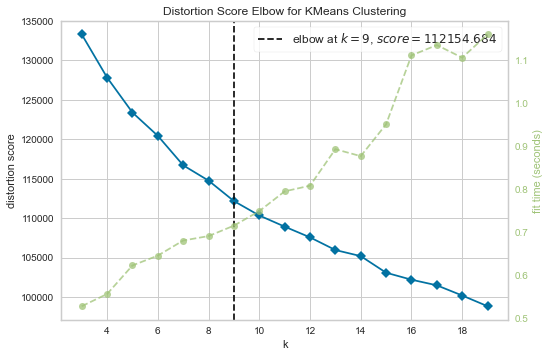

In [171]:
result = kelbow_visualizer(KMeans(random_state=4), database_notitle , k = (3, 20))

In [176]:
kmeans = KMeans(n_clusters = 9).fit(database_notitle )
cluster_target = kmeans.predict(database_notitle)
svd = TruncatedSVD(n_components = 2)

X_svd = svd.fit_transform(tf_idf_matrix)
X_svd_df = pd.DataFrame(X_svd)
X_svd_df.reset_index(drop = True, inplace = True)
titles.reset_index(drop = True, inplace = True)

X_svd_df['titles'] = titles


fig = px.scatter(
    pd.DataFrame(X_svd_df), x = 0, y = 1,
    color = cluster_target,
    title = "Image Clustering",
    hover_data ={'titles':True}
)

fig.update_layout(
    xaxis_title="1 Dimension Reduction",
    yaxis_title="2 Dimension Reduction",
)

fig.show()

In [180]:
matrix_similarity[np.tril_indices(matrix_similarity.shape[0])] = -2

In [234]:
np.argsort(matrix_similarity.ravel())

array([     0, 603765, 603766, ..., 591591, 282728, 524958], dtype=int64)

In [237]:
top_cosine_similarity = pd.DataFrame()
k = matrix_similarity.shape[0]
# Get top k similarities and pair GUID in ascending order
top_k_indexes = np.unravel_index(np.argsort(matrix_similarity.ravel()), matrix_similarity.shape)

In [244]:
np.argsort(matrix_similarity.ravel())

array([     0, 603765, 603766, ..., 591591, 282728, 524958], dtype=int64)

In [255]:
top_cosine_similarity = pd.DataFrame()
k = matrix_similarity.shape[0]
cosine_bound = 0.8
batch = len(matrix_similarity.ravel())/100
for i in range(1, int(batch)):
    np.arange(0, len(matrix_similarity.ravel()), 100)
    # Get top k similarities and pair GUID in ascending order
    top_k_indexes = np.unravel_index(np.argsort(matrix_similarity.ravel())[-k*i:], matrix_similarity.shape)
    top_k_similarities = matrix_similarity[top_k_indexes]
    top_k_pair = []
    for index in range(k):
        index_left = top_k_indexes[0][index]
        index_right = top_k_indexes[1][index]
        value = {
            "left_title": image_similarity.database.iloc[index_left]["title"],
            "right_title": image_similarity.database.iloc[index_right]["title"],
            "cosine_similarity" : matrix_similarity[index_left, index_right]
            }
        if matrix_similarity[index_left, index_right] < cosine_bound:
            break
        top_cosine_similarity = top_cosine_similarity.append(value, ignore_index = True)
    else:
        top_cosine_similarity = top_cosine_similarity.append(value, ignore_index = True)
    break

In [256]:
top_cosine_similarity

,left_title,right_title,cosine_similarity
0,lenovo legin ryzen 7 5800h rtx 3050ti 16g 512 ...,lenovo legion pro ryzen 7 5800h rtx 3070 2k 1t...,0.841700
1,kit teclado mouse inalmbrico logitech mk220 es...,teclado gamer redragon vata pro k580rgbpro qwe...,0.841708
2,kit teclado mouse inalmbrico logitech mk220 es...,teclado gamer redragon vata pro k580rgbpro qwe...,0.841708
3,teclado gamer nibio impact mk500 qwerty espaol...,teclado gamer bluetooth logitech serie g g915 ...,0.841709
4,portatil lenovo 315ada05 amd ryzen 5 3500u8gb2...,porttil ideapad 5 pro intel core i7 16gb 512gb...,0.841733
...,...,...,...
946,torre cpu intel core i7 12700 uhd 770 1tb 16gb pc,torre cpu gamer core i9 11900 gpu 2gb hdmi 1tb...,1.000000
947,ereader kindle paperwhite 10 gen 32gb azul pan...,ereader kindle paperwhite 10 gen 8gb azul pant...,1.000000
948,torre cpu intel core i7 12700 uhd 770 1tb 16gb pc,torre cpu gamer core i9 11900 gpu 2gb hdmi 1tb...,1.000000
949,torre cpu intel core i9 12900 uhd 770 1tb 16gb pc,torre cpu gamer core i9 11900 gpu 2gb hdmi 1tb...,1.000000


In [52]:
from scipy.spatial import distance
metric = 'cosine'
dc = distance.cdist([embedding_image], [embedding_image], metric)[0]

array([2.22044605e-16])

In [31]:
# ----------------------------
# Test outputs 
# ----------------------------

# clean texts
ejem_text = "Laptop Hp 245 G7 Negra 14 , Amd 3020e  8gb De Ram 1tb Hdd, Amd Radeon Rx Vega 3 1366x768px Windows 10 Home"
ejem_text = text_similarity.clean_text(ejem_text)
print(f"Clean Text {ejem_text}")
ejem_text_ngram = text_similarity.ngrams(ejem_text, n =3)
print(f"N-gram Text {ejem_text_ngram}")



Clean Text laptop hp 245 g7 negra 14 amd 3020e 8gb ram 1tb hdd amd radeon rx vega 3 1366x768px windows 10 home
N-gram Text ['lap', 'apt', 'pto', 'top', 'op ', 'p h', ' hp', 'hp ', 'p 2', ' 24', '245', '45 ', '5 g', ' g7', 'g7 ', '7 n', ' ne', 'neg', 'egr', 'gra', 'ra ', 'a 1', ' 14', '14 ', '4 a', ' am', 'amd', 'md ', 'd 3', ' 30', '302', '020', '20e', '0e ', 'e 8', ' 8g', '8gb', 'gb ', 'b r', ' ra', 'ram', 'am ', 'm 1', ' 1t', '1tb', 'tb ', 'b h', ' hd', 'hdd', 'dd ', 'd a', ' am', 'amd', 'md ', 'd r', ' ra', 'rad', 'ade', 'deo', 'eon', 'on ', 'n r', ' rx', 'rx ', 'x v', ' ve', 'veg', 'ega', 'ga ', 'a 3', ' 3 ', '3 1', ' 13', '136', '366', '66x', '6x7', 'x76', '768', '68p', '8px', 'px ', 'x w', ' wi', 'win', 'ind', 'ndo', 'dow', 'ows', 'ws ', 's 1', ' 10', '10 ', '0 h', ' ho', 'hom', 'ome']
